In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import pickle
import pylab
import numpy as np
import scipy
import torch.optim as optim
import pandas as pd
import torchvision.datasets as datasets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import shapiro, normaltest

from torchvision import transforms

from copy import deepcopy

# Local imports
from local_models import *
from helper_functions import *
from piece_hurdle_model import *

from IPython.display import Image

from PIL import Image

# torch.autograd.set_detect_anomaly(True)
%load_ext autoreload
%autoreload 2


d:\Master_ML\iml\AAAI-2021\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
G, cnn = load_models(CNN, Generator)
train_loader, test_loader = load_dataloaders()
train_loader_fashion, test_loader_fashion = load_dataloaders_fashion()

### find a incorrect classified example

Label: 8
Prediction: 3


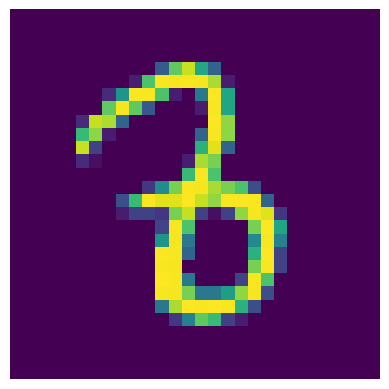

In [3]:
alpha = 0.001
rand_num = 14  # pick incorrectly classified instance as an example

# Get Query representations
original_query_idx, original_query_img, target_class = get_missclassificaiton(test_loader, cnn, rand_num)
original_query_pred = int(torch.argmax(cnn(original_query_img)[0]))

### locate in GAN

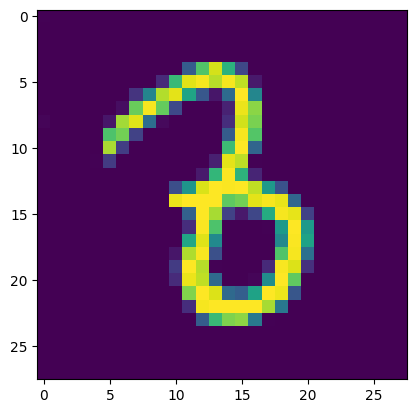

In [4]:
rand_num = 14
z = torch.load("data/latent_g_input_saved/incorrect_latent/misclassify_" + str(rand_num) + ".pt") 
output = G(z)
img_GANs = output.detach().squeeze().numpy()
plt.imshow(img_GANs)

In [5]:
query_x = cnn(G(z))[1][0]
type(query_x)

torch.Tensor

In [6]:
#### ========== First step of PIECE Algorithm ========== ####
# Step 1: Acquire the probability of each features, 
# and identify the excpetional ones (i.e., those with a probability lower than alpha)
df = acquire_feature_probabilities( target_class, cnn,
                                   original_query_img,
                                   alpha)   # target_class which is the true label
df

,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type
0,0,-0.0000,False,False,False,False,0.0294,0.0463,0.0000,gamma
1,1,0.1077,False,False,False,False,0.6185,0.1278,0.0022,norm
2,2,0.2462,False,False,False,False,0.9763,0.0993,0.0012,norm
3,3,-0.0009,False,False,False,False,0.0145,0.3195,0.0000,gamma With Fixed 0 Location
4,4,0.2091,False,False,False,False,0.8692,0.1964,0.0201,norm
...,...,...,...,...,...,...,...,...,...,...
123,123,0.0006,False,False,False,False,0.1102,0.1785,0.0000,gamma With Fixed 0 Location
124,124,-0.1466,False,False,True,False,0.0361,0.0000,0.0000,gamma With Fixed 0 Location
125,125,-0.0009,False,False,False,False,0.0305,0.1649,0.0000,gamma With Fixed 0 Location
126,126,-0.0007,False,False,False,False,0.0647,0.1272,0.0007,gamma With Fixed 0 Location


In [7]:
# Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class
df = filter_df_of_exceptional_noise(df, target_class, cnn, alpha)
# Sort by least probable to the most probable
df = df.sort_values('Probability of Event')
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type
81,81,-0.1864,False,False,True,False,0.0393,0.0000,0.0000,expon With Fixed 0 Location
104,104,-0.1862,False,False,True,False,0.0337,0.0000,0.0000,expon With Fixed 0 Location
90,90,-0.1095,False,False,True,False,0.0442,0.0000,0.0000,gamma With Fixed 0 Location
55,55,-0.1788,False,False,True,False,0.0290,0.0000,0.0000,expon With Fixed 0 Location
124,124,-0.1466,False,False,True,False,0.0361,0.0000,0.0000,gamma With Fixed 0 Location
63,63,-0.2317,False,False,True,False,0.0576,0.0000,0.0000,gamma With Fixed 0 Location
31,31,-0.1647,False,False,True,False,0.0528,0.0000,0.0000,gamma With Fixed 0 Location
89,89,-0.1499,False,False,True,False,0.0290,0.0000,0.0000,gamma With Fixed 0 Location
122,122,-0.0744,False,False,True,False,0.0466,0.0000,0.0000,gamma With Fixed 0 Location
8,8,0.0068,False,False,False,True,0.6197,0.0000,0.0373,gamma


In [8]:
print("% Features Changed to Expected Value:", 100 * df.shape[0] / 128)

% Features Changed to Expected Value: 21.875


In [9]:
criterion = nn.MSELoss()

In [10]:
def modifying_exceptional_features_each_step(df, target_class, query_activations):
    """
    Change all exceptional features to the expected value for each PDF
    return: tensor with all exceptional features turned into "expected" feature values for c'
    
    """
    # z_e = z.clone().detach().float().requires_grad_(True)
    # optimizer = optim.Adam([z_e], lr=0.001)
    ideal_xp = query_activations.clone().detach()
    count = 0
    logic_list = []
    pred_list = []
    
    # ideal_xp_list = list()

    for idx, row in df.sort_values('Probability of Event', ascending=True).iterrows():  # from least probable feature to most probable
        count += 1
        z_e = z.clone().detach().float().requires_grad_(True)
        optimizer = optim.Adam([z_e], lr=0.001)
        ideal_xp = ideal_xp.detach()
        feature_idx = int(row['Feature Map'])  
        expected_value = row['Expected Value'] 
        ideal_xp[feature_idx] = expected_value
        # ideal_xp_list.append(ideal_xp)
        # print(idx)
        
        # for iteration in range(len(ideal_xp_list)):
        
        for i in range(500):
            optimizer.zero_grad()
            logits, x_e = cnn(G(z_e))
            loss = criterion(x_e[0], ideal_xp)

            loss.backward()  
            optimizer.step()  


        print("Iteration:", count)
        
        gen_tensor = G(z_e)
        logic, x = cnn(gen_tensor)
        print("Prob of each classes", logic.detach().numpy())
        logic_list.append(logic.detach().numpy())
        print("prediction: ", torch.argmax(logic).detach().numpy())
        pred_list.append(torch.argmax(logic).detach().numpy())
        
        gen_img = gen_tensor.detach().numpy()[0][0]
        # save_path = f'counterfactual_explanation/missclassified_8_{idx}'
        plt.imshow(gen_img)
        plt.savefig(f'{count}_output_image_feature_map_{idx}.png')
        plt.show()
        
    

    return ideal_xp, logic_list, pred_list

Iteration: 1
Prob of each classes [[-2.733932   -3.469762    3.1353393   7.147697   -6.1006904  -1.8681408
   0.13734496 -1.7506145   6.294336   -0.79566056]]
prediction:  3


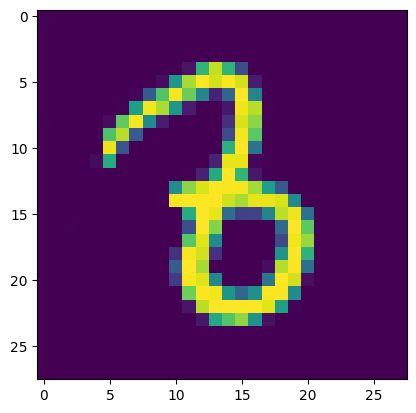

Iteration: 2
Prob of each classes [[-2.614919   -3.3903556   2.9275138   6.7519245  -5.9439654  -1.9476857
   0.32747814 -1.9134003   6.5330925  -0.7337044 ]]
prediction:  3


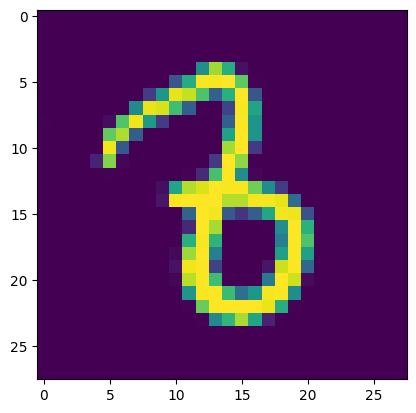

Iteration: 3
Prob of each classes [[-2.4318824  -3.3998196   2.769202    6.5394325  -5.8472786  -2.0273662
   0.47147128 -2.0985014   6.582422   -0.56180316]]
prediction:  8


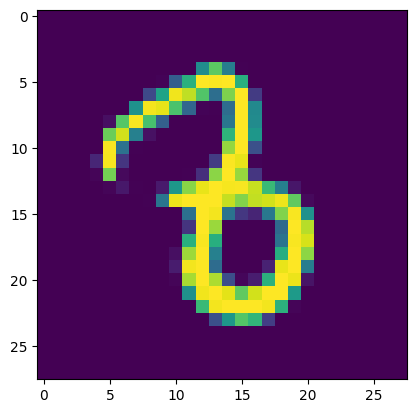

Iteration: 4
Prob of each classes [[-2.2116017  -3.375521    2.6663609   6.161486   -5.5995326  -2.0211735
   0.64765537 -2.349533    6.690188   -0.6125406 ]]
prediction:  8


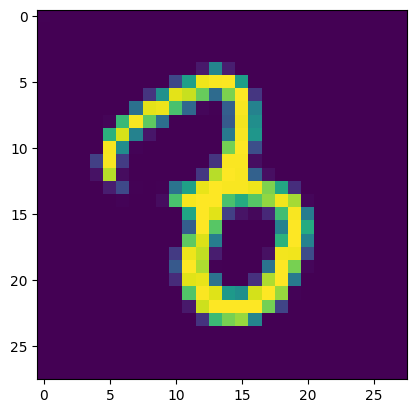

Iteration: 5
Prob of each classes [[-2.114447   -3.6186864   2.464185    5.989466   -5.5181947  -1.9873066
   0.77863204 -2.5004165   6.883115   -0.38069636]]
prediction:  8


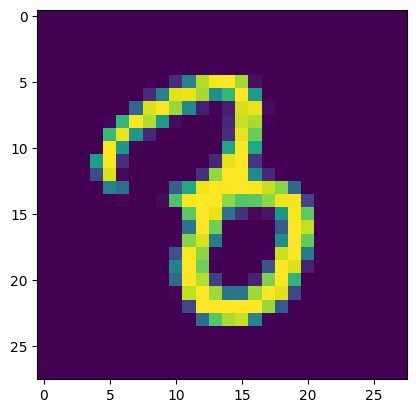

Iteration: 6
Prob of each classes [[-2.3747253  -3.3611658   2.0185218   5.598283   -5.0267224  -1.8327277
   0.676116   -2.919224    7.5369477  -0.31980848]]
prediction:  8


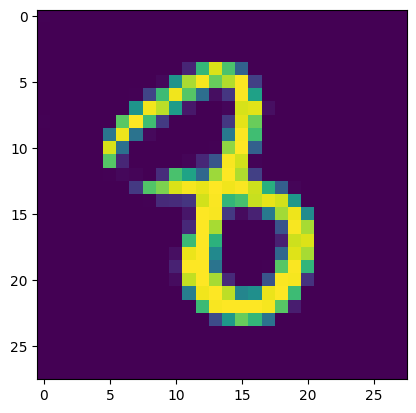

Iteration: 7
Prob of each classes [[-2.27216    -3.356561    1.7348795   5.1742034  -4.7667985  -1.7744386
   0.661168   -3.2995577   7.9227395  -0.02831183]]
prediction:  8


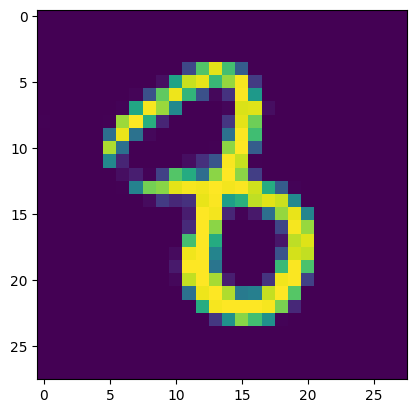

Iteration: 8
Prob of each classes [[-2.2495956  -3.3667662   1.6965127   5.041865   -4.707035   -1.7759362
   0.7031251  -3.3982513   8.031482    0.01970495]]
prediction:  8


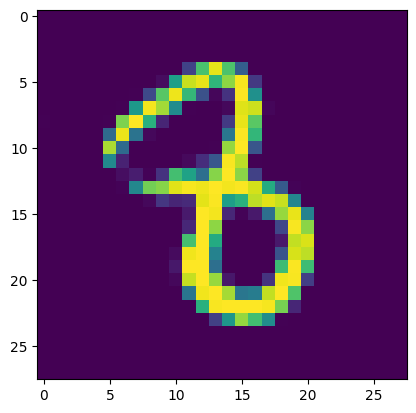

Iteration: 9
Prob of each classes [[-2.2436898  -3.3993542   1.6492698   4.974475   -4.6694508  -1.7495662
   0.7905073  -3.4794197   8.065253    0.05708982]]
prediction:  8


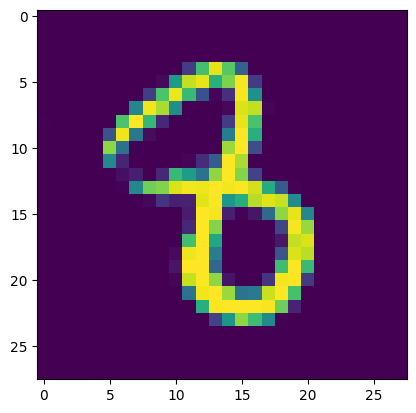

Iteration: 10
Prob of each classes [[-2.226687   -3.4275405   1.6880314   4.8655405  -4.6238074  -1.8148223
   0.7390175  -3.5088687   8.183494    0.12064357]]
prediction:  8


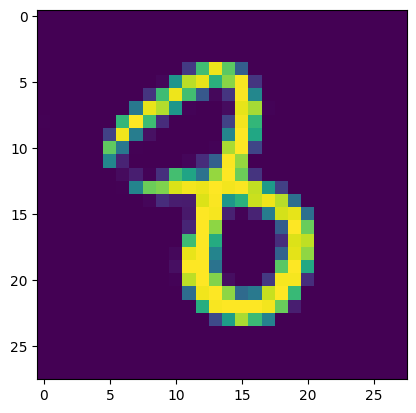

Iteration: 11
Prob of each classes [[-2.1509657  -3.5006804   1.7918801   4.7416553  -4.610432   -1.9281232
   0.5556022  -3.4632242   8.273027    0.28602594]]
prediction:  8


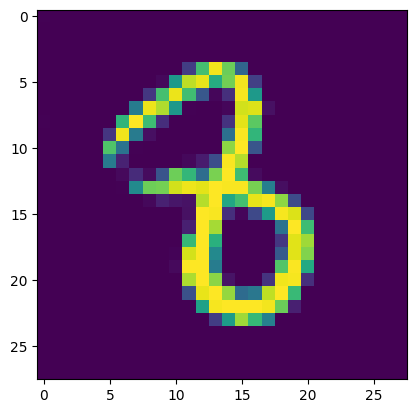

Iteration: 12
Prob of each classes [[-2.0597782  -3.626832    1.6110595   4.701328   -4.562973   -1.8995733
   0.48573914 -3.649433    8.668042    0.32701403]]
prediction:  8


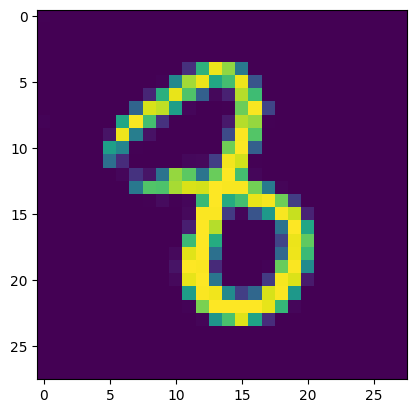

Iteration: 13
Prob of each classes [[-2.019795   -3.611569    1.5369339   4.580173   -4.4726453  -1.8881096
   0.48742875 -3.7210186   8.742432    0.36070913]]
prediction:  8


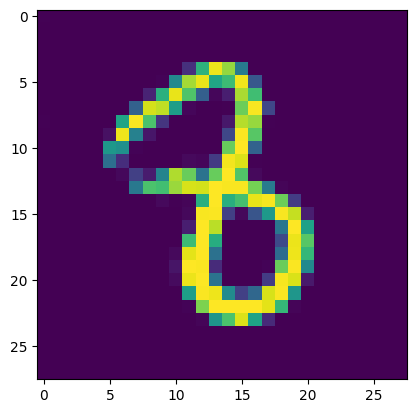

Iteration: 14
Prob of each classes [[-1.9818211  -3.6010096   1.4604394   4.4269443  -4.375897   -1.9041743
   0.46719185 -3.8205662   8.916012    0.40728414]]
prediction:  8


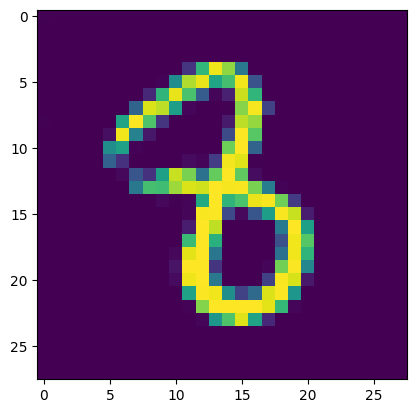

Iteration: 15
Prob of each classes [[-1.9846034  -3.6030953   1.4202361   4.3986573  -4.349753   -1.8960364
   0.48070684 -3.870619    8.987911    0.41096765]]
prediction:  8


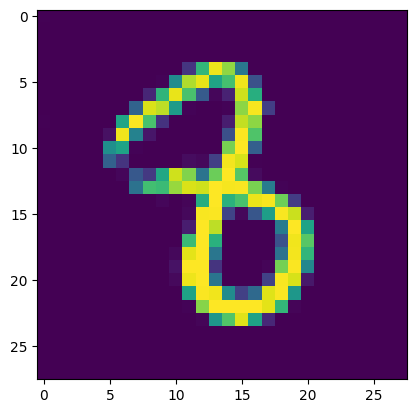

Iteration: 16
Prob of each classes [[-1.9200784  -3.589894    1.3630399   4.2989507  -4.3037314  -1.9730557
   0.3931779  -3.9573352   9.220991    0.46210134]]
prediction:  8


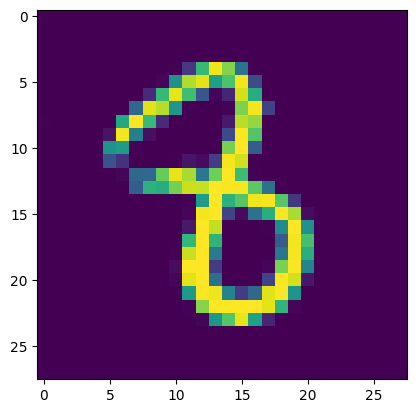

Iteration: 17
Prob of each classes [[-1.8601798  -3.6672118   1.3355098   4.052374   -4.2353764  -2.0097747
   0.42903247 -4.0916615   9.468651    0.5726457 ]]
prediction:  8


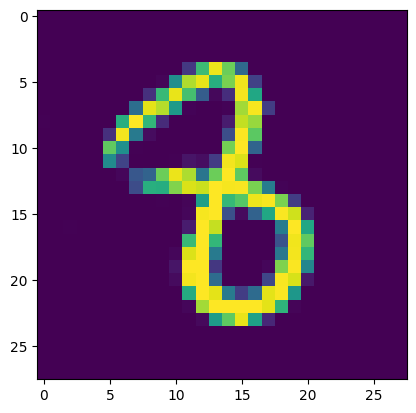

Iteration: 18
Prob of each classes [[-1.8512994 -3.7401178  1.2144296  3.9681556 -4.1592607 -1.9198912
   0.4569179 -4.222073   9.564547   0.6825314]]
prediction:  8


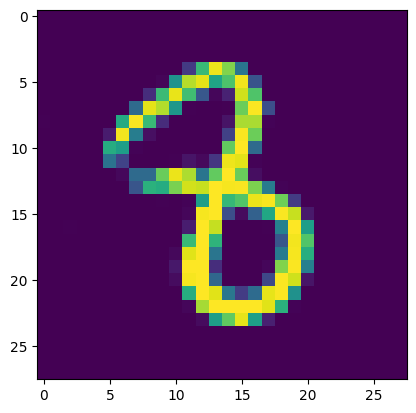

Iteration: 19
Prob of each classes [[-1.8566886 -3.7905085  1.158792   3.9014127 -4.12352   -1.85779
   0.5072435 -4.32779    9.611063   0.7716826]]
prediction:  8


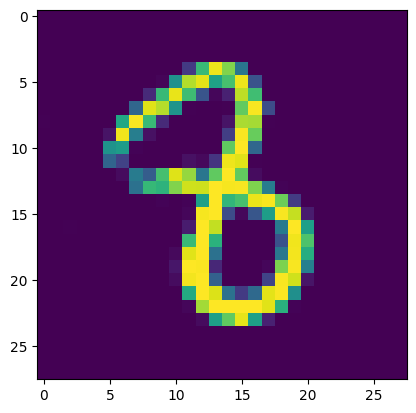

Iteration: 20
Prob of each classes [[-1.7526618 -3.848718   1.234808   3.714119  -4.091993  -2.0113578
   0.411343  -4.3224587  9.802729   0.8579009]]
prediction:  8


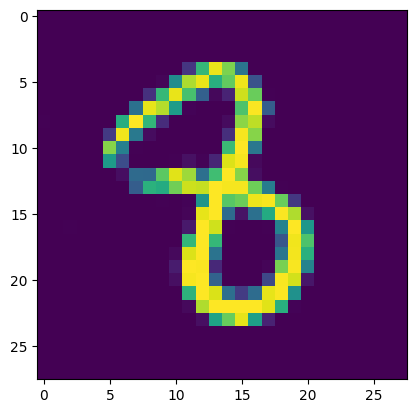

Iteration: 21
Prob of each classes [[-1.8703139 -3.3922508  1.2332051  3.5147245 -3.8462522 -2.1130538
   0.2594054 -4.271151   9.829887   0.6494221]]
prediction:  8


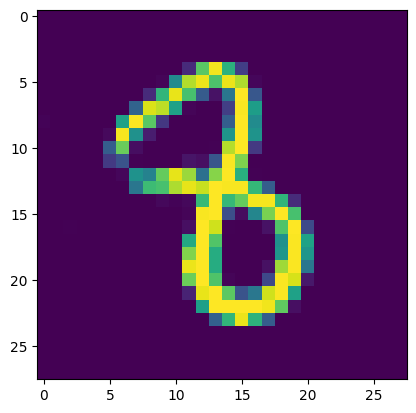

Iteration: 22
Prob of each classes [[-1.9338013  -3.3947356   1.1691089   3.5059142  -3.7963667  -2.054768
   0.24001023 -4.293236    9.866938    0.6845473 ]]
prediction:  8


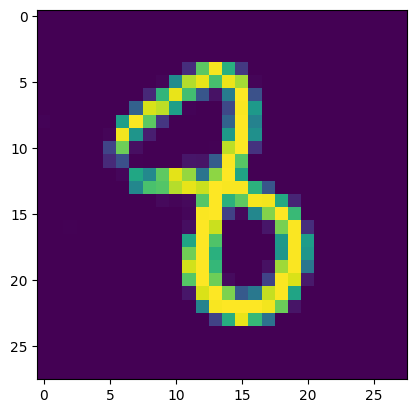

Iteration: 23
Prob of each classes [[-1.9855752  -3.6983635   1.1788323   3.444147   -3.7812076  -1.9269197
   0.47464874 -4.3808374   9.947147    0.7219041 ]]
prediction:  8


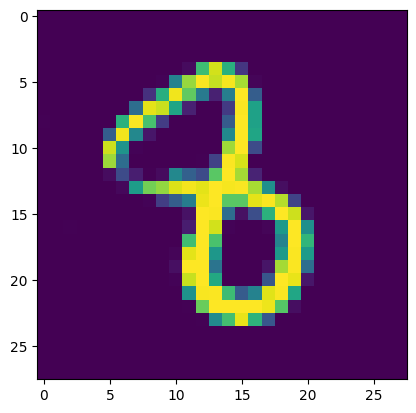

Iteration: 24
Prob of each classes [[-2.0068555  -3.6483693   1.1276207   3.442175   -3.7753117  -1.8770907
   0.5120263  -4.4137125   9.90995     0.72336644]]
prediction:  8


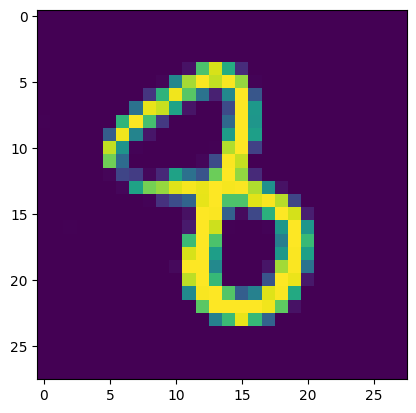

Iteration: 25
Prob of each classes [[-1.9705734  -3.6669343   1.1769311   3.2763524  -3.6996677  -2.0039058
   0.43095532 -4.4495826  10.092012    0.8080384 ]]
prediction:  8


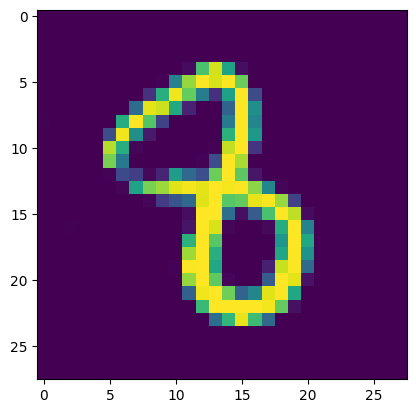

Iteration: 26
Prob of each classes [[-1.9943895  -3.6182542   1.1247115   3.2232907  -3.6321943  -1.9851835
   0.41253325 -4.4830604  10.1175      0.8286473 ]]
prediction:  8


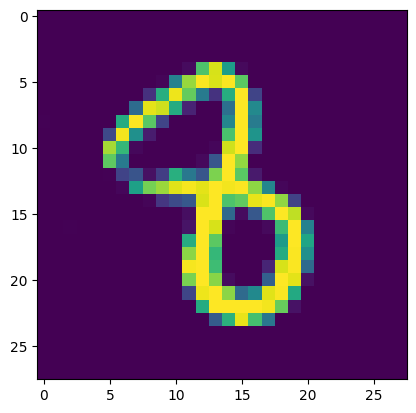

Iteration: 27
Prob of each classes [[-1.9616852 -3.6230974  1.1018971  3.1481605 -3.5342743 -1.9776859
   0.3611482 -4.3844376 10.07547    0.7881874]]
prediction:  8


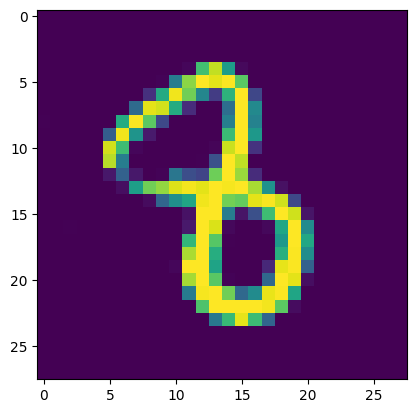

Iteration: 28
Prob of each classes [[-1.9600885  -3.6805913   1.0659376   3.1345236  -3.5596926  -1.955605
   0.41919336 -4.510818   10.196866    0.84387225]]
prediction:  8


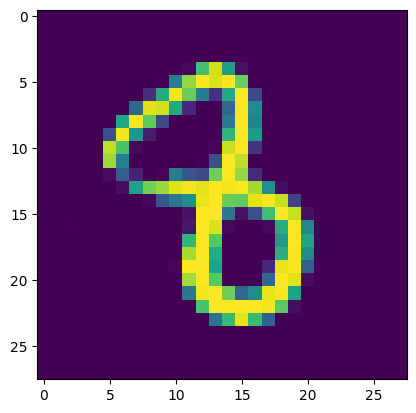

In [11]:
_, logic_list, pred_list = modifying_exceptional_features_each_step(df, target_class, query_x)

In [21]:
np_logic, np_pred= np.array(logic_list).squeeze(), np.array(pred_list)



In [25]:
np.savetxt('np_logic.csv', np_logic, delimiter=',')
np.savetxt('np_pred.csv', np_pred, delimiter=',')

In [6]:
np_prob  = np.zeros(np_logic.shape)

for i in range(len(np_logic)):
    exp_logic = np.exp(np_logic[i, :])
    np_prob[i] = exp_logic / np.sum(exp_logic) 
    
np_prob.shape

(28, 10)

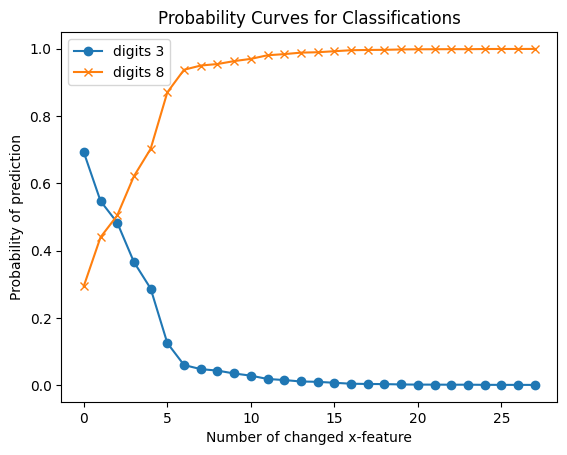

In [8]:
number_changed_x = np.arange(0, len(np_logic), 1)
plt.plot(number_changed_x, np_prob[:, 3], label='digits 3', marker='o')
plt.plot(number_changed_x, np_prob[:, 8], label='digits 8', marker='x')

plt.title('Probability Curves for Classifications')
plt.xlabel('Number of changed x-feature')
plt.ylabel('Probability of prediction')
plt.legend()

plt.show()